In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#importing libraries
import os
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [ ]:
#Dataset googledrive path
BASE_DIR = "/content/drive/My Drive/Final_Year_Project/Epic and CSCR hospital Dataset/Epic and CSCR hospital Dataset"

TRAIN_DIR = os.path.join(BASE_DIR, "Train")
TEST_DIR  = os.path.join(BASE_DIR, "Test")
VAL_DIR = os.path.join(BASE_DIR, "Val")
print("Train exists:", os.path.exists(TRAIN_DIR))
print("Test exists:", os.path.exists(TEST_DIR))
print("Val exists:", os.path.exists(VAL_DIR))#this is used below


Train exists: True
Test exists: True
Val exists: False


In [ ]:
#image parameters
IMG_SIZE = (224, 224)
BATCH_SIZE = 32


In [ ]:
#Data Augmentation + Generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(
    rescale=1./255
)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)


Found 9652 images belonging to 4 classes.
Found 2414 images belonging to 4 classes.


In [ ]:
#class verification
print(train_generator.class_indices)

{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


In [ ]:
#import model components
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam


In [ ]:
#LOAD PRETRAINED RESNET50 (CORE STEP)
base_model = ResNet50(
    weights="imagenet",
    include_top=False,
    input_shape=(224, 224, 3)
)

# Freeze all layers (important for baseline)
for layer in base_model.layers:
    layer.trainable = False


In [ ]:
#ADD CUSTOM CLASSIFICATION HEAD
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)

output = Dense(4, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=output)


In [ ]:
#compile model
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

In [ ]:
#model summary
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,113,284 (91.98 MB)

 Trainable params: 525,572 (2.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:


#callback
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

callbacks = [
    EarlyStopping(
        monitor="val_loss",
        patience=5,
        restore_best_weights=True
    ),
    ModelCheckpoint(
        "resnet50_baseline.h5",
        monitor="val_accuracy",
        save_best_only=True
    )
]


In [ ]:
#creating folder for validation with Train and Test
import os

BASE_DIR = "/content/drive/My Drive/Final_Year_Project/Epic and CSCR hospital Dataset/Epic and CSCR hospital Dataset"

TRAIN_DIR = os.path.join(BASE_DIR, "Train")
VAL_DIR   = os.path.join(BASE_DIR, "Val")

os.makedirs(VAL_DIR, exist_ok=True)

print("Val folder ready ✅")

Val folder ready ✅


In [ ]:
#Copying 20% of the image
import os
import shutil
import random

SPLIT_RATIO = 0.2  # 20%

for class_name in os.listdir(TRAIN_DIR):
    class_train_path = os.path.join(TRAIN_DIR, class_name)
    class_val_path = os.path.join(VAL_DIR, class_name)

    if not os.path.isdir(class_train_path):
        continue

    os.makedirs(class_val_path, exist_ok=True)

    images = os.listdir(class_train_path)
    random.shuffle(images)

    split_count = int(len(images) * SPLIT_RATIO)
    val_images = images[:split_count]

    for img in val_images:
        src = os.path.join(class_train_path, img)
        dst = os.path.join(class_val_path, img)
        shutil.copy(src, dst)

    print(f"{class_name}: {len(val_images)} images moved to Val")

pituitary: 500 images moved to Val
glioma: 604 images moved to Val
meningioma: 436 images moved to Val
notumor: 389 images moved to Val


In [ ]:
#verify
for cls in os.listdir(VAL_DIR):
    print(cls, "→", len(os.listdir(os.path.join(VAL_DIR, cls))))

pituitary → 500
glioma → 604
meningioma → 436
notumor → 389


In [ ]:
#Image data generator
#VAL/TEST for fair evaluation
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.1,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
#key generators
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

val_generator = val_datagen.flow_from_directory(
    VAL_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

Found 9652 images belonging to 4 classes.
Found 1929 images belonging to 4 classes.
Found 2414 images belonging to 4 classes.


In [ ]:
#confirm class labels
print(train_generator.class_indices)

{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


In [ ]:
#Callbacks(safety+intelligence during training)
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [ ]:
callbacks = [
    EarlyStopping(
        monitor="val_loss",
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),

    ModelCheckpoint(
        "/content/drive/My Drive/Final_Year_Project/best_model.keras",
        monitor="val_accuracy",
        save_best_only=True,
        verbose=1
    ),

    ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.3,
        patience=3,
        min_lr=1e-6,
        verbose=1
    )
]

In [ ]:
for layer in model.layers[-40:]:
    layer.trainable = True

#unfreezing resnet layers

In [ ]:
#compile the model
from tensorflow.keras.optimizers import Adam
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)


In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.array([0,1,2,3]),
    y=train_generator.classes
)

class_weights = dict(enumerate(class_weights))


In [ ]:

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=callbacks,
    class_weight=class_weights
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 550ms/step - accuracy: 0.6168 - loss: 0.9100
Epoch 1: val_accuracy improved from -inf to 0.67755, saving model to /content/drive/My Drive/Final_Year_Project/best_model.keras
302/302 ━━━━━━━━━━━━━━━━━━━━ 227s 632ms/step - accuracy: 0.6170 - loss: 0.9097 - val_accuracy: 0.6776 - val_loss: 0.9031 - learning_rate: 1.0000e-04
Epoch 2/20
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 541ms/step - accuracy: 0.7455 - loss: 0.6379
Epoch 2: val_accuracy improved from 0.67755 to 0.80404, saving model to /content/drive/My Drive/Final_Year_Project/best_model.keras
302/302 ━━━━━━━━━━━━━━━━━━━━ 177s 578ms/step - accuracy: 0.7455 - loss: 0.6379 - val_accuracy: 0.8040 - val_loss: 0.6068 - learning_rate: 1.0000e-04
Epoch 3/20
302/302 ━━━━━━━━━━━━━━━━━━━━ 0s 521ms/step - accuracy: 0.7645 - loss: 0.6038
Epoch 3: val_accuracy did not improve from 0.80404
302/302 ━━━━━━━━━━━━━━━━━━━━ 167s 551ms/step - accuracy: 0.7645 - loss: 0.6038 - val_accuracy: 0.7543 - val_loss: 0.7718 - lea

In [ ]:
from tensorflow.keras.models import load_model
model = load_model("/content/drive/My Drive/Final_Year_Project/best_model.keras")

In [ ]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 55,646,862 (212.28 MB)

 Trainable params: 15,766,788 (60.15 MB)

 Non-trainable params: 8,346,496 (31.84 MB)

 Optimizer params: 31,533,578 (120.29 MB)

In [ ]:
#Evaluate on test data
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy*100:.2f}%")

76/76 ━━━━━━━━━━━━━━━━━━━━ 1850s 25s/step - accuracy: 0.8407 - loss: 0.4515
Test Accuracy: 87.95%


In [ ]:
print("Train samples:", train_generator.samples)
print("Validation samples:", val_generator.samples)
print("Test samples:", test_generator.samples)

print("Train classes:", train_generator.class_indices)
print("Test classes:", test_generator.class_indices)

Train samples: 9652
Validation samples: 1929
Test samples: 2414
Train classes: {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}
Test classes: {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


76/76 ━━━━━━━━━━━━━━━━━━━━ 20s 208ms/step


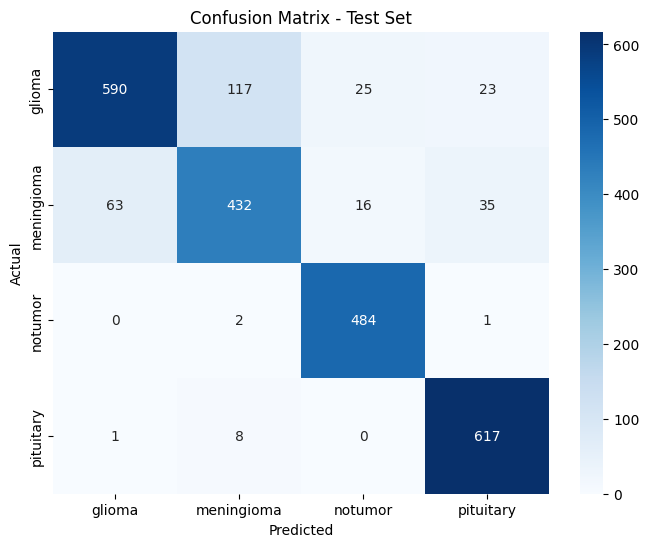

              precision    recall  f1-score   support

      glioma       0.90      0.78      0.84       755
  meningioma       0.77      0.79      0.78       546
     notumor       0.92      0.99      0.96       487
   pituitary       0.91      0.99      0.95       626

    accuracy                           0.88      2414
   macro avg       0.88      0.89      0.88      2414
weighted avg       0.88      0.88      0.88      2414



In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Get true labels
y_true = test_generator.classes

# Predict
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# Plot
plt.figure(figsize=(8,6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=test_generator.class_indices.keys(),
    yticklabels=test_generator.class_indices.keys()
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Test Set")
plt.show()

# Classification Report
print(classification_report(
    y_true,
    y_pred,
    target_names=test_generator.class_indices.keys()
))

In [ ]:
#saving model
model.save("/content/drive/My Drive/Final_Year_Project/brain_tumor_final.keras")

In [ ]:
#last convolution layer
for layer in model.layers[::-1]:
    if "conv" in layer.name.lower():
        print(layer.name)
        break


conv5_block3_out


In [ ]:
#Gradcam
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


In [ ]:
#test image
from tensorflow.keras.preprocessing import image

img_path = "/content/drive/My Drive/Final_Year_Project/Epic and CSCR hospital Dataset/Epic and CSCR hospital Dataset/Test/glioma/1100.jpg"

img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = img_array / 255.0


In [ ]:
#generate heatmap
last_conv_layer = "conv5_block3_out"

heatmap = make_gradcam_heatmap(
    img_array,
    model,
    last_conv_layer
)


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer_1']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


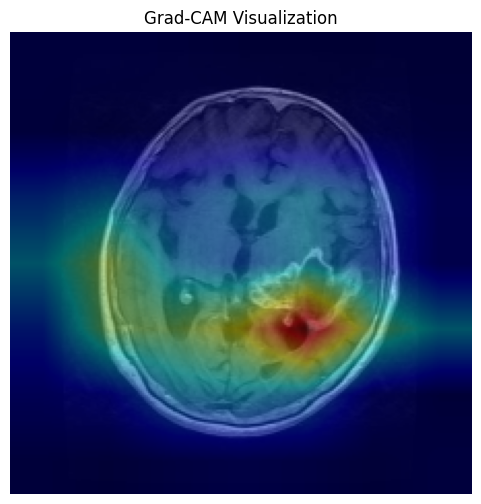

In [ ]:
#overlay heatmap on MRI
img = cv2.imread(img_path)
img = cv2.resize(img, (224, 224))

heatmap = cv2.resize(heatmap, (224, 224))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)

plt.figure(figsize=(6,6))
plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("Grad-CAM Visualization")
plt.show()


In [ ]:
#strating single image function to use it later
CLASS_NAMES = ['glioma', 'meningioma', 'notumor', 'pituitary']

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image

def predict_single_image(model, img_path, img_size=(224, 224)):
    """
    Predicts tumor class for a single MRI image

    Args:
        model: trained Keras model
        img_path: path to image file
        img_size: input size expected by model

    Returns:
        predicted_class (str)
        confidence (float)
    """

    # Load image
    img = image.load_img(img_path, target_size=img_size)
    img_array = image.img_to_array(img)

    # Normalize (same as training)
    img_array = img_array / 255.0

    # Add batch dimension
    img_array = np.expand_dims(img_array, axis=0)

    # Predict
    predictions = model.predict(img_array)

    # Get class index & confidence
    predicted_index = np.argmax(predictions[0])
    confidence = float(np.max(predictions[0]))

    predicted_class = CLASS_NAMES[predicted_index]

    return predicted_class, confidence


In [ ]:
#testing the function
img_path = "/content/drive/My Drive/Final_Year_Project/Epic and CSCR hospital Dataset/Epic and CSCR hospital Dataset/Test/meningioma/1298.jpg"

pred_class, conf = predict_single_image(model, img_path)

print(f"Predicted Class: {pred_class}")
print(f"Confidence: {conf*100:.2f}%")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Predicted Class: meningioma
Confidence: 99.25%
